In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

In [10]:
def func(x):
  return (np.sin(x) * x - (10 * x))

In [11]:
x = np.linspace(-1,1,100)

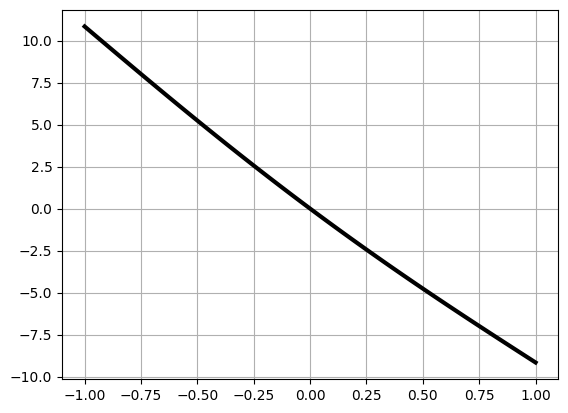

In [13]:
plt.plot(x,func(x),color='k',lw=3)
plt.grid(True)
plt.show()

In [14]:
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
# define the discriminator model
model_discriminator = define_discriminator()
# summarize the model
model_discriminator.summary()
# plot the model
#plot_model(model_discriminator, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               300       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [20]:
def generate_real_samples(n,l=-1,h=1):
  # generate inputs in [-l, h]
  x_1 = l+(h-l)*np.random.random(size=n)

  x_2 = func(x_1)

  x_1 = x_1.reshape(n, 1)
  x_2 = x_2.reshape(n, 1)
  x = np.hstack((x_1, x_2))

  y = np.ones((n, 1))
  return x, y

In [21]:
generate_real_samples(5)

(array([[-0.86780502,  9.3401088 ],
        [-0.84580279,  9.09111439],
        [ 0.6828366 , -6.39749877],
        [ 0.63231242, -5.94942021],
        [ 0.20961418, -2.05252471]]),
 array([[1.],
        [1.],
        [1.],
        [1.],
        [1.]]))

In [23]:
def generate_fake_samples(n,l=-1,h=1):
  # generate inputs in [-l, h]
  x_1 = l+(h-l)*np.random.random(size=n)
  x_2 = l+(h-l)*np.random.random(size=n)
  x_1 = x_1.reshape(n, 1)
  x_2 = x_2.reshape(n, 1)
  x = np.hstack((x_1, x_2))
  y = np.zeros((n, 1))
  return x, y

In [24]:
generate_fake_samples(5)

(array([[ 0.46418146,  0.69016541],
        [-0.39043152, -0.51276022],
        [-0.21768033, -0.2272694 ],
        [-0.52279231, -0.90697084],
        [ 0.41537148,  0.84039835]]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]))

In [25]:
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    # run epochs manually
    for i in range(n_epochs):
        # generate real examples
        X_real, y_real = generate_real_samples(half_batch)
        # update model
        model.train_on_batch(X_real, y_real)
        # generate fake examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update model
        model.train_on_batch(X_fake, y_fake)
        # evaluate the model
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
        print(i, acc_real, acc_fake)

In [26]:
train_discriminator(model_discriminator,n_epochs=20)

0 0.0 1.0
1 0.0 1.0
2 0.0 1.0
3 0.0 1.0
4 0.0 1.0
5 0.0 1.0
6 0.0 1.0
7 0.0 0.984375
8 0.015625 0.96875
9 0.0 0.953125
10 0.0 0.90625
11 0.0 0.890625
12 0.0 0.890625
13 0.015625 0.75
14 0.0 0.78125
15 0.015625 0.625
16 0.015625 0.71875
17 0.03125 0.671875
18 0.03125 0.515625
19 0.03125 0.625


In [27]:
x_t,y_t=generate_fake_samples(5)
model_discriminator.evaluate(x_t,y_t)

1/1 [==============================] - 0s 69ms/step - loss: 0.5869 - accuracy: 0.8000


[0.5868695378303528, 0.800000011920929]

In [28]:
# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

In [29]:
# define the discriminator model
model_gen = define_generator(5)
# summarize the model
model_gen.summary()
# plot the model (does not work on my windows laptop, needs proper installation of pydot and graphviz)
# plot_model(model_gen, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 50)                300       
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 402
Trainable params: 402
Non-trainable params: 0
_________________________________________________________________


In [30]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n,l=-1,h=1):
    # generate points in the latent space
    x_input = l+(h-l)*np.random.random(size=latent_dim*n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [31]:
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # plot the results
    plt.scatter(X[:, 0], X[:, 1],color='k',s=15)
    plt.show()

4/4 [==============================] - 0s 1ms/step


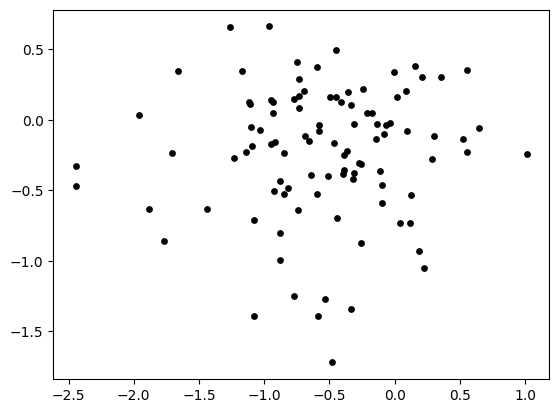

In [32]:
# size of the latent space
latent_dim = 5
# define the discriminator model
model_gen = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(model_gen, latent_dim, 100)

In [33]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y

In [34]:
# define the combined generator and discriminator model, for updating the generator
def full_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [35]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
model_gan = full_gan(generator, discriminator)
# summarize gan model
model_gan.summary()
# plot gan model (does not work on my windows laptop, needs proper installation of pydot and graphviz)
#plot_model(model_gan, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 2)                 402       
                                                                 
 sequential_3 (Sequential)   (None, 1)                 401       
                                                                 
Total params: 803
Trainable params: 402
Non-trainable params: 401
_________________________________________________________________


In [36]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n=500):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print ("Data comparison after {} epochs".format(epoch+1))
    print()
    print("Accuracy for the real data: {}, Accuracy for the fake data: {}".format(acc_real, acc_fake))
    print()
    plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
    plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    plt.show()
    print()

In [37]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=256, n_eval=1000):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

In [38]:
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
model_gan = full_gan(generator, discriminator)

16/16 [==============================] - 0s 491us/step


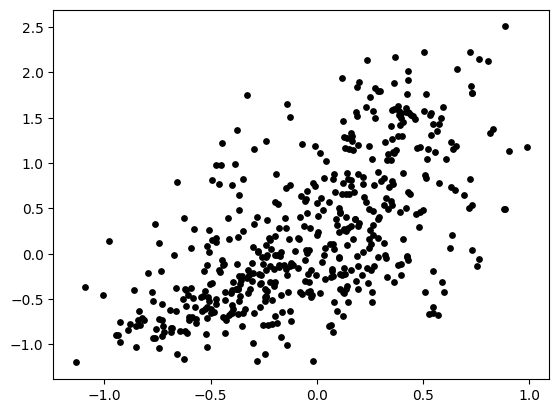

In [39]:
n=500
x,_=generate_fake_samples(generator, latent_dim, n)
plt.scatter(x[:,0],x[:,1],color='k',s=15)
plt.show()

In [40]:
# train model
train(generator, discriminator, model_gan, latent_dim)

4/4 [==============================] - 0s 1000us/step


4/4 [==============================] - 0s 1000us/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1ms/step


4/4 [==============================] - 0s 1000us/step


KeyboardInterrupt: 

In [ ]:
latent_dim=5
n=200
x,_=generate_fake_samples(generator, latent_dim, n)
plt.scatter(x[:,0],x[:,1],color='k',s=15)
plt.show()